<a href="https://colab.research.google.com/github/dev-S-t/Fraud_Detection/blob/main/Clutch2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction and Data Description**


---




#### The data is broken into **two files identity and transaction,** which are **joined by TransactionID**. Not all transactions have corresponding identity information.
https://www.kaggle.com/c/ieee-fraud-detection/data?select=test_transaction.csv



> ### **Categorical Features - Transaction**

* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

> ### **Categorical Features - Identity**

* DeviceType
* DeviceInfo
* id_12 - id_38


> ### **Transaction Table**

* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.         
`(card4 = card issuer name and card6 = debit or credit)`
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.


> ### **Identity Table**

* Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
* They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)


# **Loading Data**


---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import gc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# sample_df = pd.read_csv("/content/drive/MyDrive/ieee-fraud-detection/sample_submission.csv")
# test_id = pd.read_csv("/content/drive/MyDrive/ieee-fraud-detection/test_identity.csv")
# test_transaction = pd.read_csv("/content/drive/MyDrive/ieee-fraud-detection/test_transaction.csv")
train_id = pd.read_csv("/content/drive/MyDrive/ieee-fraud-detection/train_identity.csv")
train_transaction = pd.read_csv("/content/drive/MyDrive/ieee-fraud-detection/train_transaction.csv")

In [4]:
train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Data Preprocessing**


---



### Merge datasets

In [6]:
train = train_transaction.merge(train_id, on='TransactionID', how='left')
del train_id
del train_transaction
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


In [7]:
gc.collect()

0

### Memory Reduction and sorting

In [8]:
## Memory Reducer by GEMINI
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
train= reduce_mem_usage(train)

Mem. usage decreased to 645.97 Mb (67.0% reduction)


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float16(354), float32(45), int16(1), int32(2), int8(1), object(31)
memory usage: 646.0+ MB


In [11]:
train.sort_values(by='TransactionDT' , inplace=True)
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


# NULLS and EDA


---



In [12]:
def show_nulls(train):
    null_percentages = (train.isnull().sum() / len(train)) * 100
    # Create a bar chart with interactive zoom/pan and column names
    fig = px.bar(x=train.columns, y=null_percentages, labels={'x': 'Column Name', 'y': 'Percentage of Null Values (%)'})
    fig.update_layout(xaxis_title='Column Name', yaxis_title='Percentage of Null Values (%)')
    fig.update_xaxes(range=[0, len(train.columns)])  # Set x-axis range for better display
    fig.show()
show_nulls(train)

Ratio of fraudulent cases: 0.03499000914417313
Ratio of non-fraudulent cases: 0.9650099908558268


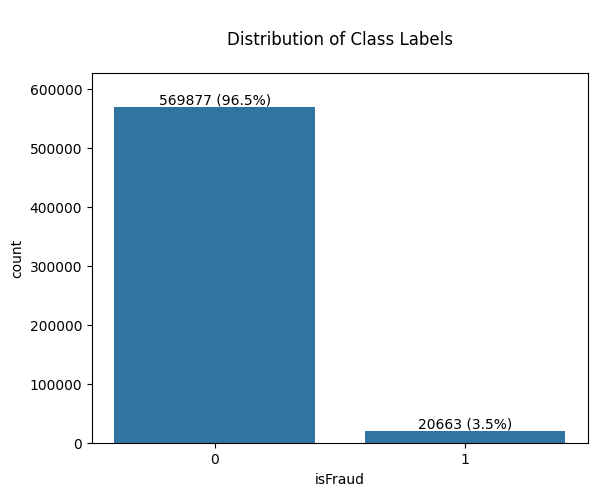

In [13]:
# Count the occurrences of fraud and no fraud
occ = train['isFraud'].value_counts()


ratio_cases = occ/len(train.index)
print(f'Ratio of fraudulent cases: {ratio_cases[1]}\nRatio of non-fraudulent cases: {ratio_cases[0]}')
###

ax = sns.countplot(x='isFraud', data = train)

plt.title("\nDistribution of Class Labels\n")

plt.margins(0.05, 0.1)

for p in ax.patches:
  x=p.get_bbox().get_points()[:,0]
  y=p.get_bbox().get_points()[1,1]
  ax.annotate('{} ({:.1f}%)'.format(int(y),100.*y/len(train)), (x.mean(), y),
          ha='center', va='bottom')

plt.show()

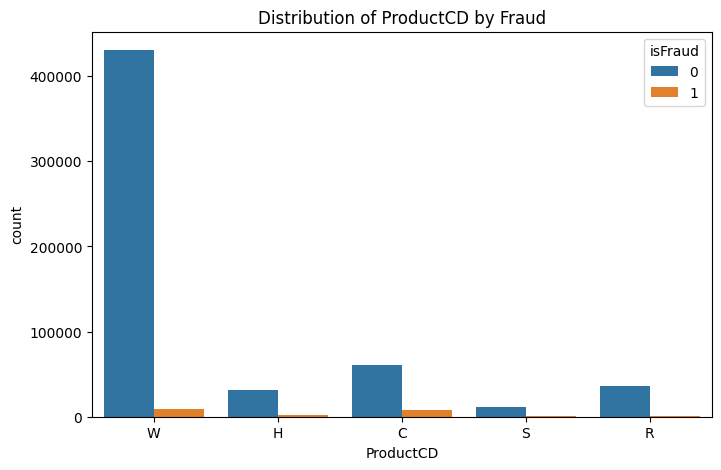

In [14]:
# Visualize the distribution of 'ProductCD'
plt.figure(figsize=(8, 5))
sns.countplot(x='ProductCD', hue='isFraud', data=train)
plt.title('Distribution of ProductCD by Fraud')
plt.show()

In [15]:
reference_date = pd.to_datetime('2017-11-30')
train['TransactionDate'] = reference_date + pd.to_timedelta(train['TransactionDT'], unit='s')
# Group by date and isFraud
fraud_trends = train.groupby([train['TransactionDate'].dt.date, 'isFraud']).size().unstack(fill_value=0)


<ipython-input-15-14c29cf5b8d3>:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



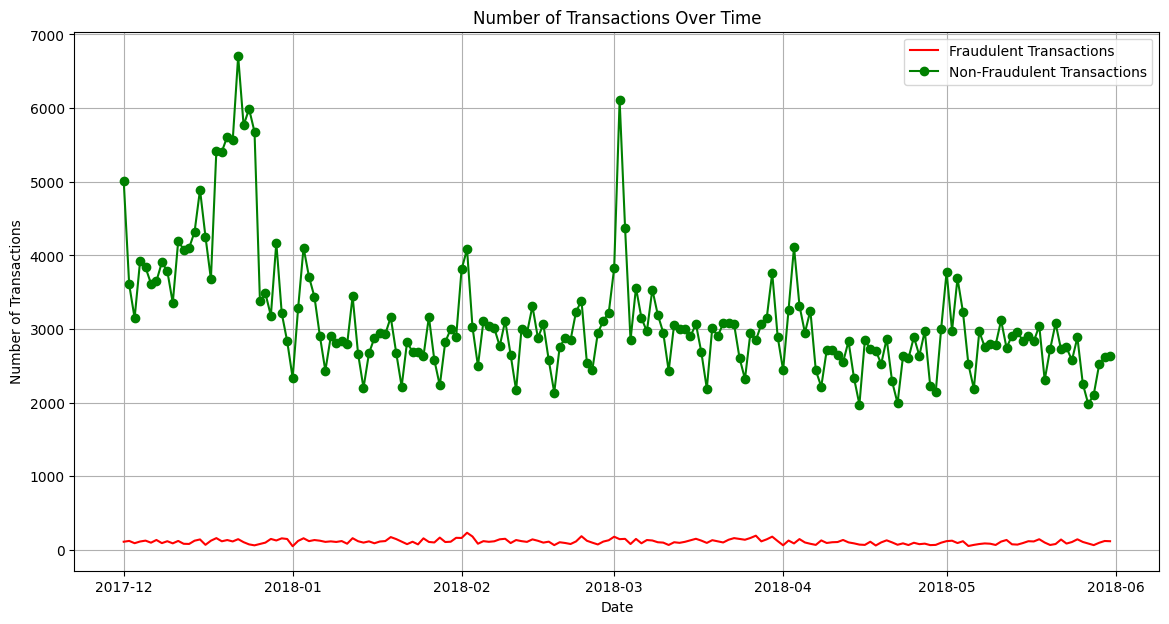

In [16]:
# Plotting the data
plt.figure(figsize=(14, 7))

plt.plot(fraud_trends.index, fraud_trends[1], label='Fraudulent Transactions', color='red')
plt.plot(fraud_trends.index, fraud_trends[0], label='Non-Fraudulent Transactions', color='green',marker='o')

plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions Over Time')
plt.legend()
plt.grid(True)
plt.show()

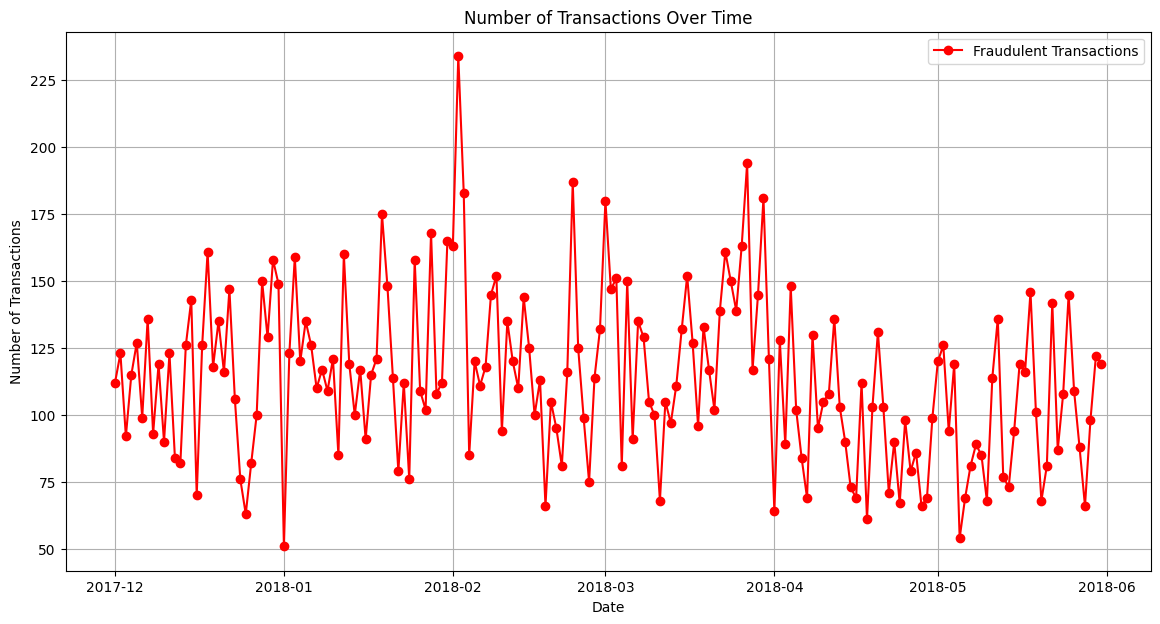

In [17]:
# Plotting the data
plt.figure(figsize=(14, 7))

plt.plot(fraud_trends.index, fraud_trends[1], label='Fraudulent Transactions', color='red', marker ='o')
# plt.plot(fraud_trends.index, fraud_trends[0], label='Non-Fraudulent Transactions', color='green')

plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Feature Engineering


---



### Correcting MetaData

In [18]:
reference_date = pd.to_datetime('2017-11-30')
train['TransactionDate'] = reference_date + pd.to_timedelta(train['TransactionDT'], unit='s')
train['TransactionDate']

0        2017-12-01 00:00:00
1        2017-12-01 00:00:01
2        2017-12-01 00:01:09
3        2017-12-01 00:01:39
4        2017-12-01 00:01:46
                 ...        
590535   2018-05-31 23:57:27
590536   2018-05-31 23:57:29
590537   2018-05-31 23:57:59
590538   2018-05-31 23:58:08
590539   2018-05-31 23:58:51
Name: TransactionDate, Length: 590540, dtype: datetime64[ns]

### Extract time-based features from TransactionDate




In [32]:
train['Transaction_hour'] = train['TransactionDate'].dt.hour
train['Transaction_day'] = train['TransactionDate'].dt.day
train['Transaction_month'] = train['TransactionDate'].dt.month
train['Transaction_dayofweek'] = train['TransactionDate'].dt.dayofweek

<ipython-input-32-9597901b2981>:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-32-9597901b2981>:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-32-9597901b2981>:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-32-9597901b2981>:4: PerformanceWarning:

Da

### New col : user_id

In [19]:
train['user_id'] = train['TransactionDate'] - pd.to_timedelta(train['D1'], unit='d')
# Convert user_id to string to treat it as a categorical feature
train['user_id'] = train['user_id'].astype(str)

# Fill NA values with a placeholder for categorical features
train['user_id'].fillna('unknown', inplace=True)
train['user_id'].describe()

<ipython-input-19-a66c96177fa9>:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



count     590540
unique    579745
top          NaT
freq        1269
Name: user_id, dtype: object

### New col : Data_Available

There can be a direct coorelation between the amount of data present for the trnstion and it being  a fraaud

In [20]:
train['Data_Available'] = (train.notnull().sum(axis=1)/434) * 100
train['Data_Available'].describe()

<ipython-input-20-0dae2509562b>:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



count    590540.000000
mean         55.386458
std          11.298609
min          22.119816
25%          47.695853
50%          51.843318
75%          52.534562
max          94.930876
Name: Data_Available, dtype: float64

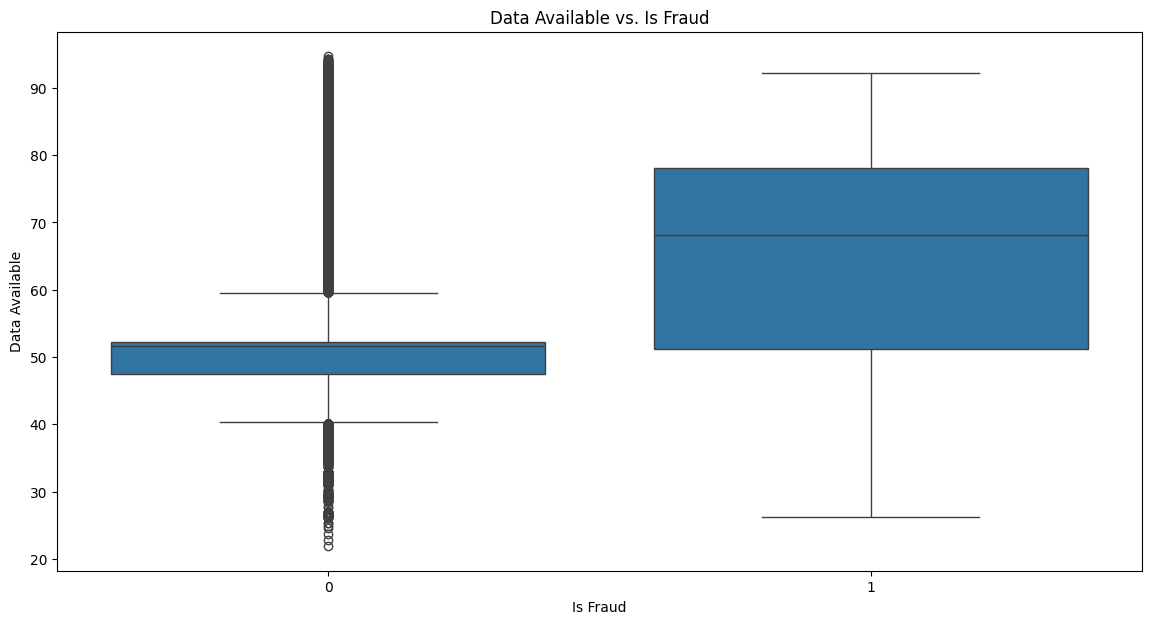

In [23]:
plt.figure(figsize=(14, 7))
sns.boxplot(x='isFraud', y='Data_Available', data=train)
plt.xlabel('Is Fraud')
plt.ylabel('Data Available')
plt.title('Data Available vs. Is Fraud')
plt.show()

<ipython-input-24-3fb6eabe5f18>:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-24-3fb6eabe5f18>:4: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




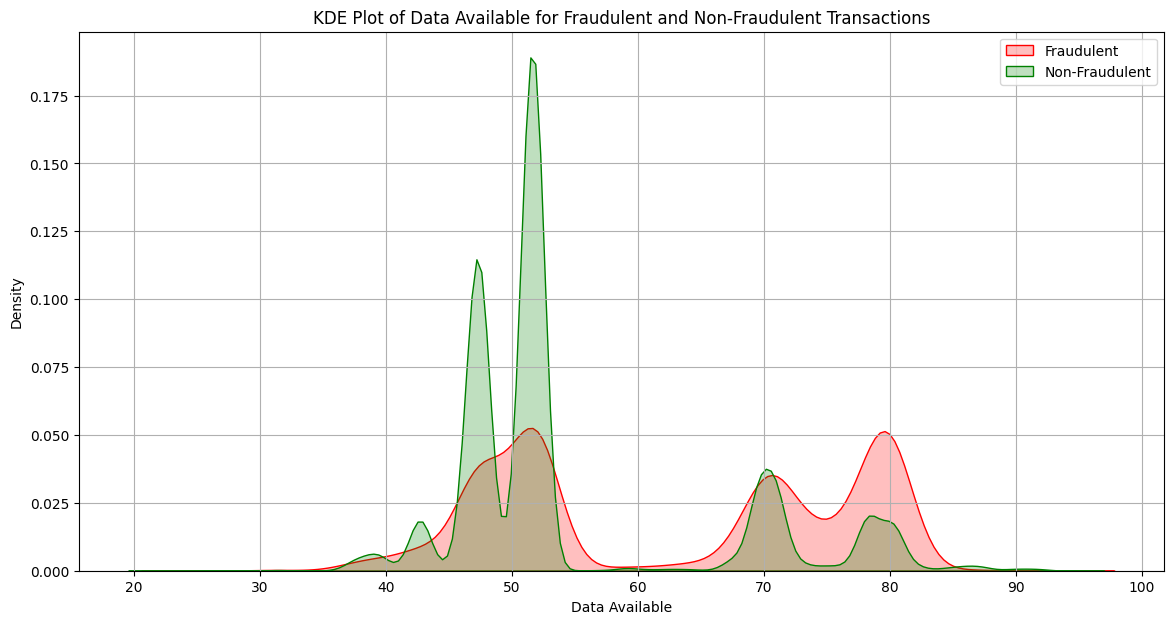

In [24]:
#KDE
plt.figure(figsize=(14, 7))
sns.kdeplot(train[train['isFraud'] == 1]['Data_Available'], shade=True, color='red', label='Fraudulent')
sns.kdeplot(train[train['isFraud'] == 0]['Data_Available'], shade=True, color='green', label='Non-Fraudulent')
plt.xlabel('Data Available')
plt.ylabel('Density')
plt.title('KDE Plot of Data Available for Fraudulent and Non-Fraudulent Transactions')
plt.legend()
plt.grid(True)
plt.show()

### Handling Nulls

In [21]:
 def missing_info(df):

  temp = pd.DataFrame(index=df.columns)
  temp["Datatype"] = df.dtypes
  temp["Not null values"] = df.count
  temp["Null values"] = df.isnull().sum()
  temp["Percentage of Null values"] = (df.isnull().mean()) * 100
  temp["Unique count"] = df.nunique()

  return temp

missing_info(train)

,Datatype,Not null values,Null values,Percentage of Null values,Unique count
TransactionID,int32,<bound method DataFrame.count of Trans...,0,0.000000,590540
isFraud,int8,<bound method DataFrame.count of Trans...,0,0.000000,2
TransactionDT,int32,<bound method DataFrame.count of Trans...,0,0.000000,573349
TransactionAmt,float16,<bound method DataFrame.count of Trans...,0,0.000000,8195
ProductCD,object,<bound method DataFrame.count of Trans...,0,0.000000,5
...,...,...,...,...,...
DeviceType,object,<bound method DataFrame.count of Trans...,449730,76.155722,2
DeviceInfo,object,<bound method DataFrame.count of Trans...,471874,79.905510,1786
TransactionDate,datetime64[ns],<bound method DataFrame.count of Trans...,0,0.000000,573349
user_id,object,<bound method DataFrame.count of Trans...,0,0.000000,579745


In [22]:
def nulls(data):
    cols = [x for x in data.columns if data[x].isnull().sum() / data.shape[0] > 0.40]
    return cols
cols_to_drop = nulls(train)
print(cols_to_drop)

['dist1', 'dist2', 'R_emaildomain', 'D2', 'D3', 'D5', 'D6', 'D7', 'D8', 'D9', 'D11', 'D12', 'D13', 'D14', 'M1', 'M2', 'M3', 'M4', 'M5', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V

In [23]:
train = train.drop(columns=cols_to_drop)
train = train.dropna(axis=0, thresh=train.shape[1]*0.35)
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V315,V316,V317,V318,V319,V320,V321,TransactionDate,user_id,Data_Available
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,0.0,0.0,117.0,0.0,0.0,0.0,0.0,2017-12-01 00:00:00,2017-11-17 00:00:00,46.543779
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-12-01 00:00:01,2017-12-01 00:00:01,47.465438
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-12-01 00:01:09,2017-12-01 00:01:09,51.843318
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,2017-12-01 00:01:39,2017-08-11 00:01:39,48.156682
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-12-01 00:01:46,2017-12-01 00:01:46,68.894009


In [29]:
show_nulls(train)

In [25]:
gc.collect()

3986

### Impute Remaining Missing Values

In [26]:
from sklearn.impute import SimpleImputer
#float16(354), float32(45), int16(1), int32(2), int8(1), object(31)
# Impute numerical columns with median
numerical_cols = train.select_dtypes(include=['float16','float32','float64','int8','int16','int32', 'int64']).columns
imputer = SimpleImputer(strategy='median')
train[numerical_cols] = imputer.fit_transform(train[numerical_cols])

# Impute categorical columns with 'Unknown'
categorical_cols = train.select_dtypes(include=['object']).columns
train[categorical_cols] = train[categorical_cols].fillna('Unknown')

# # Handling missing values in object columns
# for col in object_columns:
#     if df[col].isnull().any():
#         # Replace missing values with the mode (most frequent value) of the column
#         mode_value = df[col].mode()[0]
#         df[col] = df[col].fillna(mode_value)

# # Verify that missing values have been handled
# print(df.info())
# df.head()

In [31]:
show_nulls(train)

In [27]:
gc.collect()

0

# Final Prep

## Encoding Catagorical values

In [41]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns in train_transaction
cat_cols_transaction = [col for col in train.columns if train[col].dtype == 'object']

# Initialize LabelEncoder
le = LabelEncoder()

# Apply label encoding to each categorical column
for col in cat_cols_transaction:
    # Convert the column to string type to ensure LabelEncoder works as expected
    train[col] = train[col].astype('str')

    # Use LabelEncoder to transform the categorical values to numerical labels
    train[col] = le.fit_transform(train[col])

train['isFraud'] = train['isFraud'].astype('str')
train['isFraud'] = le.fit_transform(train['isFraud'])
train.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,V318,V319,V320,V321,user_id,Data_Available,Transaction_hour,Transaction_day,Transaction_month,Transaction_dayofweek
0,0,-0.278174,0.547250,0.821695,-0.009783,-0.281425,-2.607805,-1.396380,-1.619468,0.243321,...,-0.058049,-0.055287,-0.088855,-0.074142,-0.741487,-0.782635,0,1,12,4
1,0,-0.443337,0.547250,-1.457558,0.264810,-0.281425,-0.982065,-2.368254,-1.619468,0.347543,...,-0.058049,-0.055287,-0.088855,-0.074142,-0.666750,-0.701062,0,1,12,4
2,0,-0.317897,0.547250,-1.068263,0.813997,-0.281425,0.643675,-0.813255,0.569797,0.399654,...,-0.058049,-0.055287,-0.088855,-0.074142,-0.666732,-0.313591,0,1,12,4
3,0,-0.355529,0.547250,1.679858,1.305711,-0.281425,-0.982065,-2.003802,0.569797,1.921291,...,0.224769,-0.055287,-0.088855,-0.074142,-1.076053,-0.639882,0,1,12,4
4,0,-0.355529,-1.559603,-1.102133,0.967258,-0.281425,-0.982065,-2.368254,-1.619468,1.337649,...,-0.058049,-0.055287,-0.088855,-0.074142,-0.666714,1.195507,0,1,12,4


In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 590540 entries, 0 to 590539
Columns: 209 entries, TransactionID to Transaction_dayofweek
dtypes: datetime64[ns](1), float64(198), int32(4), int64(6)
memory usage: 937.1 MB


In [35]:
print(train.select_dtypes(include=['datetime64[ns]']).columns)

Index(['TransactionDate'], dtype='object')


In [36]:
# Drop the original datetime columns but keep the engineered features
train.drop(['TransactionID', 'TransactionDT', 'TransactionDate'], axis=1, inplace=True)


## Scaling and Normalizing

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_cols = train.select_dtypes(include=['float64', 'int64']).columns

train[numerical_cols] = scaler.fit_transform(train[numerical_cols])

## Train - Test Split

In [42]:
from sklearn.model_selection import train_test_split

X = train.drop(['isFraud'], axis=1)
y = train['isFraud']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Model Training and Evaluation

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Conclusion